# Yet another attempt to train a model that doesn't take ages
## Strategy here: first compute and save all spectrograms, then sample from spectrograms for training

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import h5py

import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

import keras
import tensorflow_io as tfio
import tensorflow_probability as tfp
import tensorflow_extra as tfe

import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

XC_ROOTDIR = '../../data/' # directory to save data in
XC_DIR = 'test_dataset10' # subdirectory name of dataset

tf.config.set_visible_devices([], 'GPU')

2024-07-04 16:35:59.854943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 16:35:59.854999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 16:35:59.856159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 16:35:59.863207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 16:36:00.812623: W tensorflow/compiler/tf2

### Read data

In [168]:
df = pd.read_csv("../../data/dataset10.csv")
#df["fullfilename"] = "../" + df["fullfilename"]

### Configuration

In [3]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 22050
    duration = 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = 32
    n_epochs = 50
    
    # class labels/names
    names = list(np.unique(df.en))
    n_classes = len(names)
    labels = list(range(n_classes))
    label2name = dict(zip(labels, names))
    name2label = {v:k for k,v in label2name.items()}

# set random seed in keras
tf.keras.utils.set_random_seed(cfg.seed)

## Load all audios, compute and save spectrograms

### Functions to compute, save and load spectrogram

In [4]:
def compute_spec(filepath, sr=cfg.sr, duration=cfg.duration, nfft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax):
    audio, sr = librosa.load(filepath, sr = sr)
    # randomly pad clip if shorter
    if len(audio) < duration*sr:
        _ = np.zeros(duration*sr)
        rand_idx = np.random.randint(0, duration*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmin = 0, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

def save_spec_to_hdf5(spec, hdf5_path, name, compression="gzip", chunks=True):
    try:
        with h5py.File(hdf5_path, 'a') as f:  # Open in append mode
            f.create_dataset(name, data=spec, compression=compression, chunks=chunks)
    except Exception as e:
        print(f'Error saving spectrograms to {hdf5_path}: {e}')

In [5]:
def compute_and_save_spec(filepath, return_length = False):
    spec = compute_spec(filepath)
    name = Path(filepath).stem
    hdf5_path = os.path.dirname(filepath) + "/spectrograms.h5"
    save_spec_to_hdf5(spec, hdf5_path = hdf5_path, name = name)
    if return_length:
        return spec.shape[-1]

def load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None):
    with h5py.File(hdf5_path, 'r') as f:
        spectrogram_slice = f[name][start_row:end_row, start_col:end_col]
    return spectrogram_slice

In [6]:
spec = compute_spec(df.fullfilename.iloc[0])
spec.shape

(128, 3226)

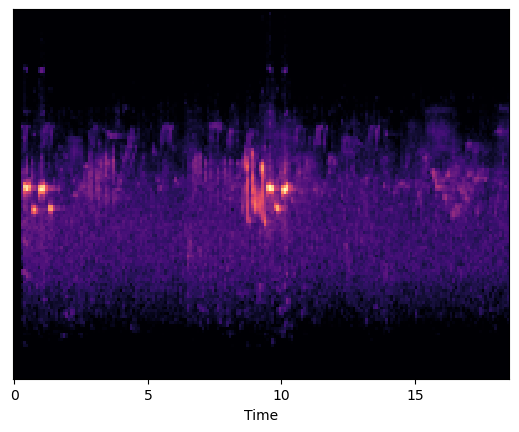

In [7]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

In [8]:
path = df.fullfilename.iloc[0]
compute_and_save_spec(path)

Error saving spectrograms to ../../data/dataset10/Turdus merula_Common Blackbird/spectrograms.h5: Unable to synchronously create dataset (name already exists)


In [9]:
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
spec.shape

(128, 3226)

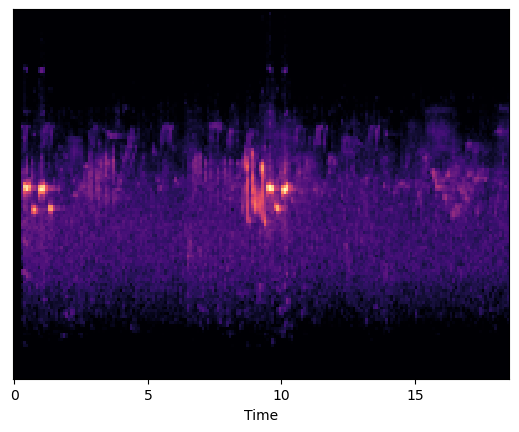

In [10]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

### Compute and save spectrograms for all audios in the dataset

In [11]:
if not "spectrogram" in df.columns:
    df["spectrogram"] = None
if not "length_spectrogram" in df.columns:
    df["length_spectrogram"] = None
for i in tqdm(range(len(df))):
    filepath = df.fullfilename.iloc[i]
    if df.loc[i, "spectrogram"] is None:
        df.loc[i, "length_spectrogram"] = compute_and_save_spec(filepath, return_length = True)
        df.loc[i, "spectrogram"] = Path(filepath).stem


df.to_csv("../../data/dataset10.csv", index = False)

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 42669.85it/s]


(128, 2866)


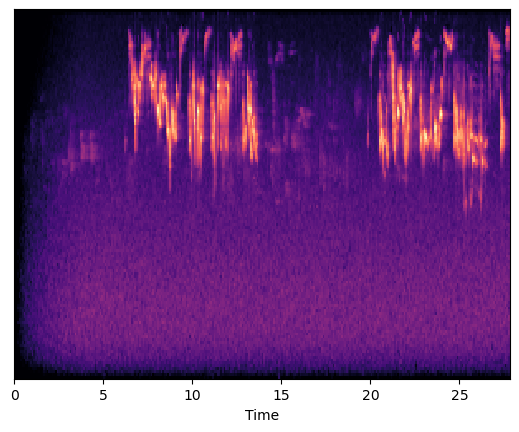

In [12]:
path = df.fullfilename.iloc[42]
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:300], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

## Create data generator for training

### Helper functions

In [13]:
# Generates random integer # from https://www.kaggle.com/code/wengsilu/birdclef24pretraining
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [14]:
cfg.input_dim[1]

162

In [15]:
def load_random_spec_slice(df, ID):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    rdm = random_int(maxval= spec_length - cfg.input_dim[1])
    return load_spectrogram_slice(hdf5_path = hdf5_path, name = name, start_col = rdm, end_col = rdm + cfg.input_dim[1])

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataframe,
                 batch_size=cfg.batch_size, 
                 dim=cfg.input_dim,
                 n_channels =  1,
                 n_classes=cfg.n_classes, 
                 shuffle=True
                ):
        'Initialization'
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.dataframe = dataframe
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_random_spec_slice(self.dataframe, ID).reshape(*self.dim, self.n_channels)
            # Store class
            y[i] = cfg.name2label[df.en.iloc[ID]]
        X = X.reshape(len(X), *self.dim, self.n_channels)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

(128, 162)
(128, 162)


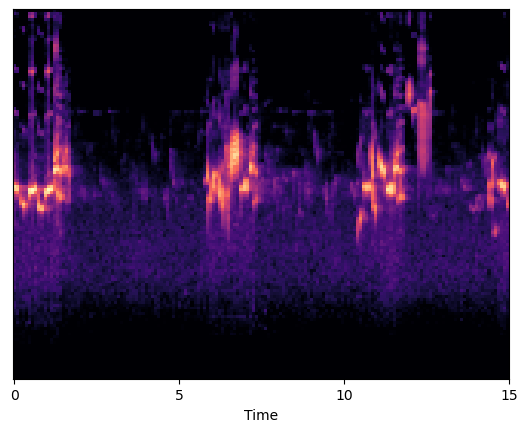

In [16]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax);
print(cfg.input_dim)

## Build model

In [17]:
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

zscore_layer = tfe.layers.ZScoreMinMax()

def build_model():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Basemodel")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

### Test zscore_layer

In [18]:
specs = []
for i in tqdm(range(50)):
    specs.append(load_random_spec_slice(df, ID = i))
specs = np.array(specs)
print("Before zscore layer: ", specs.min(), specs.max())

print("After zscore layer: ", zscore_layer(specs).numpy().min(), zscore_layer(specs).numpy().max())


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.13it/s]


Before zscore layer:  -63.894543 39.862907
After zscore layer:  0.0 1.0


In [19]:
model = build_model()

Model: "Basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 162, 1)]     0         
                                                                 
 z_score_min_max (ZScoreMin  (None, 128, 162, 1)       0         
 Max)                                                            
                                                                 
 conv2d (Conv2D)             (None, 126, 160, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 80, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 78, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 39, 64)        0 

## Train validation split

In [20]:
from sklearn.model_selection import train_test_split

id_train, id_val, y_train, y_val = train_test_split(range(len(df)), df["en"].to_list(), test_size = 0.3, random_state = cfg.seed)

training_generator = DataGenerator(id_train, y_train, df)
validation_generator = DataGenerator(id_val, y_val, df)

In [21]:
hist = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True, verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


2024-07-04 16:36:23.118624: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fee2c295210 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-04 16:36:23.118675: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-04 16:36:23.162410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720103783.571750     268 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-04 16:36:23.572827: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-04 16:36:23.576187: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-04 16:36:26.162946: E external/local_xla/xl

6/6 - 21s - loss: 2.3213 - accuracy: 0.1302 - val_loss: 2.2885 - val_accuracy: 0.1875 - 21s/epoch - 4s/step
Epoch 2/50
6/6 - 14s - loss: 2.2932 - accuracy: 0.1302 - val_loss: 2.3440 - val_accuracy: 0.0312 - 14s/epoch - 2s/step
Epoch 3/50
6/6 - 17s - loss: 2.2847 - accuracy: 0.1458 - val_loss: 2.3208 - val_accuracy: 0.0625 - 17s/epoch - 3s/step
Epoch 4/50
6/6 - 10s - loss: 2.2489 - accuracy: 0.1458 - val_loss: 2.3693 - val_accuracy: 0.0938 - 10s/epoch - 2s/step
Epoch 5/50
6/6 - 8s - loss: 2.2589 - accuracy: 0.1927 - val_loss: 2.3145 - val_accuracy: 0.0781 - 8s/epoch - 1s/step
Epoch 6/50
6/6 - 12s - loss: 2.1929 - accuracy: 0.1823 - val_loss: 2.2925 - val_accuracy: 0.1250 - 12s/epoch - 2s/step
Epoch 7/50
6/6 - 7s - loss: 2.1569 - accuracy: 0.1875 - val_loss: 2.2762 - val_accuracy: 0.1562 - 7s/epoch - 1s/step
Epoch 8/50
6/6 - 6s - loss: 2.1441 - accuracy: 0.2240 - val_loss: 2.1587 - val_accuracy: 0.1562 - 6s/epoch - 1s/step
Epoch 9/50
6/6 - 10s - loss: 2.1291 - accuracy: 0.2240 - val_loss

In [22]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

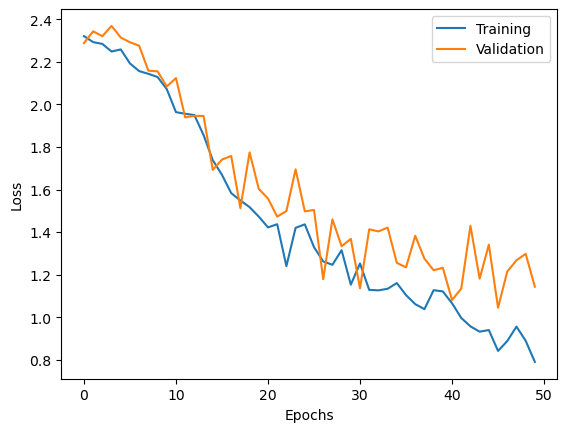

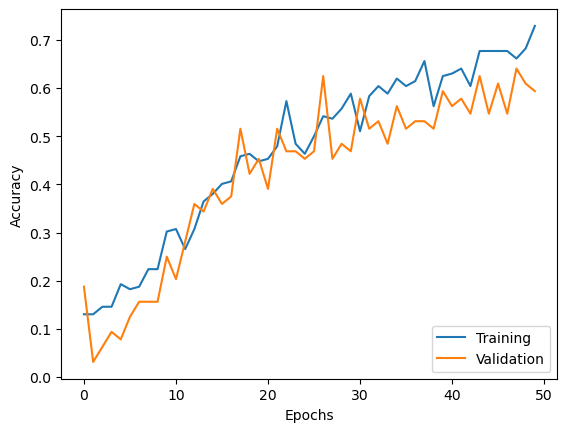

In [23]:
plot_history(hist)

### Train for another n_epochs

In [24]:
#hist2 = model.fit(training_generator, 
#                  validation_data=validation_generator,
#                  use_multiprocessing=True, verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50
6/6 - 11s - loss: 0.9450 - accuracy: 0.7083 - val_loss: 1.2743 - val_accuracy: 0.6094 - 11s/epoch - 2s/step
Epoch 2/50
6/6 - 6s - loss: 0.9476 - accuracy: 0.6510 - val_loss: 1.2359 - val_accuracy: 0.6719 - 6s/epoch - 922ms/step
Epoch 3/50
6/6 - 5s - loss: 0.8882 - accuracy: 0.6719 - val_loss: 1.2274 - val_accuracy: 0.5781 - 5s/epoch - 815ms/step
Epoch 4/50
6/6 - 5s - loss: 0.8830 - accuracy: 0.6719 - val_loss: 1.0376 - val_accuracy: 0.6562 - 5s/epoch - 815ms/step
Epoch 5/50
6/6 - 6s - loss: 0.8408 - accuracy: 0.6562 - val_loss: 1.0633 - val_accuracy: 0.6406 - 6s/epoch - 989ms/step
Epoch 6/50
6/6 - 11s - loss: 0.9016 - accuracy: 0.6354 - val_loss: 1.1128 - val_accuracy: 0.6094 - 11s/epoch - 2s/step
Epoch 7/50
6/6 - 6s - loss: 0.6803 - accuracy: 0.7656 - val_loss: 1.2816 - val_accuracy: 0.5781 - 6s/epoch - 965ms/step
Epoch 8/50
6/6 - 5s - loss: 0.7144 - accuracy: 0.7708 - val_loss: 1.2930 - val_accuracy: 0.6250 - 5s/epoch - 892ms/step
Epoch 9/50
6/6 - 5s - loss: 0.7654 - accur

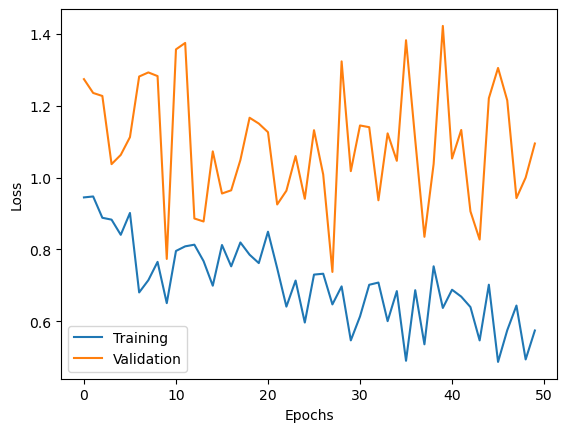

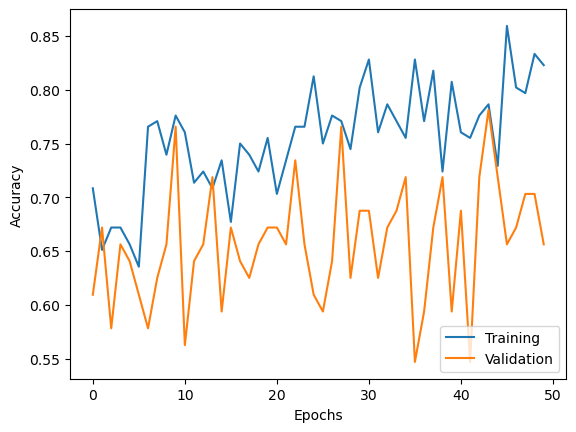

In [25]:
#plot_history(hist2)

## Predict method

    -load spectrogram
    -divide into slices
    -pad last slice if long enough
    -predict slices
    -average prediction or smth.

In [121]:
spec = load_random_spec_slice(df, 269)

model.predict(spec.reshape(1, *spec.shape, 1))

1/1 [==============================] - 0s 23ms/step


array([[1.2637120e-03, 7.5691300e-05, 8.0116908e-05, 1.5480775e-06,
        9.7357935e-01, 8.5799629e-04, 3.6878897e-05, 1.8649423e-06,
        2.4109177e-05, 2.4078814e-02]], dtype=float32)

In [118]:
def pad_spectrogram(spec, shape = cfg.input_dim, random = False):
    _ = np.zeros(shape)
    if random:
        rdm = random_int(maxval=shape[1]-spec.shape[1])
        _[:,rdm: rdm + spec.shape[1]] = spec 
    else:
        _[:,:spec.shape[1]] = spec
    return _

In [125]:
ID = 0
name = df.spectrogram.iloc[ID]
hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
spec_length = df.length_spectrogram.iloc[ID]
spec = load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None)
slices = []
for i in range(spec_length//cfg.input_dim[1]):
    slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration: # consider last slice, only if it is longer than the shortest clips in the dataset 
    slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
preds = model.predict(np.expand_dims(np.array(slices), axis = -1))

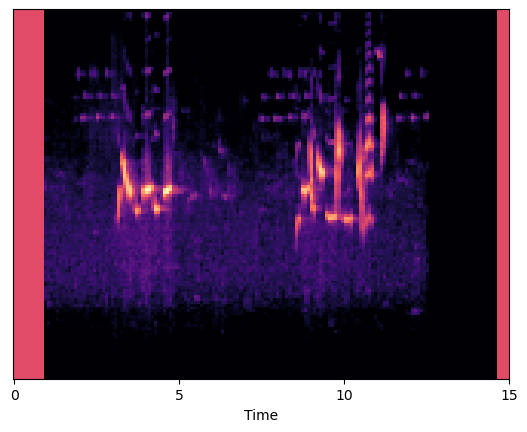

In [139]:
pad_spectrogram(slices[19]).shape

fig, ax = plt.subplots(1,1)
librosa.display.specshow(slices[19], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax);

In [142]:
def predict_file(df, ID, model):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    spec = load_spectrogram_slice(hdf5_path, name)
    slices = []
    
    for i in range(spec_length//cfg.input_dim[1]):
        slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
    if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration:
        # consider last slice, only if it is longer than the shortest clips in the dataset 
        slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
    
    preds = model.predict(np.expand_dims(np.array(slices), axis = -1))
    
    return np.mean(preds, axis = 0) # return mean prediction

In [147]:
preds = []
for i in tqdm(df.index):
    preds.append(predict_file(df, ID = i, model = model))

  0%|                                                                                           | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


  0%|▎                                                                                  | 1/300 [00:00<00:48,  6.22it/s]

1/1 [==============================] - 0s 54ms/step


  1%|▌                                                                                  | 2/300 [00:00<00:41,  7.10it/s]

1/1 [==============================] - 0s 48ms/step


  1%|▊                                                                                  | 3/300 [00:00<00:39,  7.58it/s]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                                  | 4/300 [00:00<00:36,  8.05it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▍                                                                                 | 5/300 [00:00<00:35,  8.26it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                                 | 6/300 [00:00<00:35,  8.39it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 7/300 [00:00<00:35,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                                | 8/300 [00:00<00:34,  8.53it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▍                                                                                | 9/300 [00:01<00:33,  8.59it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▋                                                                               | 10/300 [00:01<00:32,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


  4%|███                                                                               | 11/300 [00:01<00:32,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                              | 12/300 [00:01<00:32,  8.85it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███▌                                                                              | 13/300 [00:01<00:33,  8.68it/s]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                              | 14/300 [00:01<00:32,  8.72it/s]

1/1 [==============================] - 0s 43ms/step


  5%|████                                                                              | 15/300 [00:01<00:31,  8.95it/s]

1/1 [==============================] - 0s 44ms/step


  5%|████▎                                                                             | 16/300 [00:01<00:31,  9.07it/s]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                             | 17/300 [00:01<00:31,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


  6%|████▉                                                                             | 18/300 [00:02<00:31,  8.83it/s]

1/1 [==============================] - 0s 45ms/step


  6%|█████▏                                                                            | 19/300 [00:02<00:31,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


  7%|█████▍                                                                            | 20/300 [00:02<00:31,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▋                                                                            | 21/300 [00:02<00:31,  8.77it/s]

1/1 [==============================] - 0s 45ms/step


  7%|██████                                                                            | 22/300 [00:02<00:31,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▎                                                                           | 23/300 [00:02<00:31,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


  8%|██████▌                                                                           | 24/300 [00:02<00:31,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▊                                                                           | 25/300 [00:02<00:31,  8.73it/s]

1/1 [==============================] - 0s 58ms/step


  9%|███████                                                                           | 26/300 [00:03<00:32,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


  9%|███████▍                                                                          | 27/300 [00:03<00:32,  8.47it/s]

1/1 [==============================] - 0s 42ms/step


  9%|███████▋                                                                          | 28/300 [00:03<00:31,  8.74it/s]

1/1 [==============================] - 0s 42ms/step


 10%|███████▉                                                                          | 29/300 [00:03<00:30,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 10%|████████▏                                                                         | 30/300 [00:03<00:30,  8.90it/s]

1/1 [==============================] - 0s 49ms/step


 10%|████████▍                                                                         | 31/300 [00:03<00:30,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 11%|████████▋                                                                         | 32/300 [00:03<00:30,  8.66it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█████████                                                                         | 33/300 [00:03<00:30,  8.70it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█████████▎                                                                        | 34/300 [00:03<00:30,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█████████▌                                                                        | 35/300 [00:04<00:29,  8.90it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█████████▊                                                                        | 36/300 [00:04<00:29,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 12%|██████████                                                                        | 37/300 [00:04<00:31,  8.26it/s]

1/1 [==============================] - 0s 45ms/step


 13%|██████████▍                                                                       | 38/300 [00:04<00:30,  8.46it/s]

1/1 [==============================] - 0s 44ms/step


 13%|██████████▋                                                                       | 39/300 [00:04<00:30,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▉                                                                       | 40/300 [00:04<00:29,  8.68it/s]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▏                                                                      | 41/300 [00:04<00:29,  8.90it/s]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▍                                                                      | 42/300 [00:04<00:31,  8.17it/s]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▊                                                                      | 43/300 [00:05<00:30,  8.32it/s]

1/1 [==============================] - 0s 51ms/step


 15%|████████████                                                                      | 44/300 [00:05<00:29,  8.54it/s]

1/1 [==============================] - 0s 43ms/step


 15%|████████████▎                                                                     | 45/300 [00:05<00:29,  8.63it/s]

1/1 [==============================] - 0s 44ms/step


 15%|████████████▌                                                                     | 46/300 [00:05<00:29,  8.62it/s]

1/1 [==============================] - 0s 45ms/step


 16%|████████████▊                                                                     | 47/300 [00:05<00:29,  8.66it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████                                                                     | 48/300 [00:05<00:29,  8.69it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▍                                                                    | 49/300 [00:05<00:28,  8.82it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█████████████▋                                                                    | 50/300 [00:05<00:27,  8.94it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█████████████▉                                                                    | 51/300 [00:05<00:27,  9.15it/s]

1/1 [==============================] - 0s 43ms/step


 17%|██████████████▏                                                                   | 52/300 [00:05<00:26,  9.30it/s]

1/1 [==============================] - 0s 44ms/step


 18%|██████████████▍                                                                   | 53/300 [00:06<00:26,  9.32it/s]

1/1 [==============================] - 0s 45ms/step


 18%|██████████████▊                                                                   | 54/300 [00:06<00:26,  9.15it/s]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                   | 55/300 [00:06<00:26,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▎                                                                  | 56/300 [00:06<00:26,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████████████▌                                                                  | 57/300 [00:06<00:25,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████████████▊                                                                  | 58/300 [00:06<00:25,  9.44it/s]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▏                                                                 | 59/300 [00:06<00:26,  9.22it/s]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▍                                                                 | 60/300 [00:06<00:26,  9.03it/s]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▋                                                                 | 61/300 [00:06<00:26,  8.92it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▉                                                                 | 62/300 [00:07<00:26,  8.89it/s]

1/1 [==============================] - 0s 49ms/step


 21%|█████████████████▏                                                                | 63/300 [00:07<00:27,  8.73it/s]

1/1 [==============================] - 0s 43ms/step


 21%|█████████████████▍                                                                | 64/300 [00:07<00:26,  8.90it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▊                                                                | 65/300 [00:07<00:26,  8.79it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██████████████████                                                                | 66/300 [00:07<00:26,  8.87it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██████████████████▎                                                               | 67/300 [00:07<00:26,  8.66it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▌                                                               | 68/300 [00:07<00:25,  8.97it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▊                                                               | 69/300 [00:07<00:25,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


 23%|███████████████████▏                                                              | 70/300 [00:07<00:25,  8.99it/s]

1/1 [==============================] - 0s 44ms/step


 24%|███████████████████▍                                                              | 71/300 [00:08<00:25,  9.01it/s]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▋                                                              | 72/300 [00:08<00:25,  9.09it/s]

1/1 [==============================] - 0s 46ms/step


 24%|███████████████████▉                                                              | 73/300 [00:08<00:25,  8.92it/s]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▏                                                             | 74/300 [00:08<00:25,  8.91it/s]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 75/300 [00:08<00:25,  8.99it/s]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▊                                                             | 76/300 [00:08<00:24,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 26%|█████████████████████                                                             | 77/300 [00:08<00:26,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▎                                                            | 78/300 [00:08<00:25,  8.68it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████▌                                                            | 79/300 [00:09<00:24,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████▊                                                            | 80/300 [00:09<00:24,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▏                                                           | 81/300 [00:09<00:23,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████▍                                                           | 82/300 [00:09<00:25,  8.55it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██████████████████████▉                                                           | 84/300 [00:09<00:23,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 28%|███████████████████████▏                                                          | 85/300 [00:09<00:23,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▌                                                          | 86/300 [00:09<00:22,  9.41it/s]

1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████▊                                                          | 87/300 [00:09<00:22,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 29%|████████████████████████                                                          | 88/300 [00:09<00:22,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▎                                                         | 89/300 [00:10<00:21,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▌                                                         | 90/300 [00:10<00:21,  9.70it/s]

1/1 [==============================] - 0s 56ms/step


 30%|████████████████████████▊                                                         | 91/300 [00:10<00:22,  9.14it/s]

1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████▏                                                        | 92/300 [00:10<00:23,  8.85it/s]

1/1 [==============================] - 0s 51ms/step


 31%|█████████████████████████▍                                                        | 93/300 [00:10<00:24,  8.62it/s]

1/1 [==============================] - 0s 45ms/step


 31%|█████████████████████████▋                                                        | 94/300 [00:10<00:23,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 32%|█████████████████████████▉                                                        | 95/300 [00:10<00:23,  8.90it/s]

1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████▏                                                       | 96/300 [00:10<00:23,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████▌                                                       | 97/300 [00:10<00:23,  8.69it/s]

1/1 [==============================] - 0s 44ms/step


 33%|██████████████████████████▊                                                       | 98/300 [00:11<00:29,  6.83it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███████████████████████████                                                       | 99/300 [00:11<00:27,  7.40it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███████████████████████████                                                      | 100/300 [00:11<00:25,  7.89it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▎                                                     | 101/300 [00:11<00:23,  8.37it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▌                                                     | 102/300 [00:11<00:22,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▊                                                     | 103/300 [00:11<00:22,  8.88it/s]

1/1 [==============================] - 0s 45ms/step


 35%|████████████████████████████                                                     | 104/300 [00:11<00:22,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 35%|████████████████████████████▎                                                    | 105/300 [00:11<00:22,  8.73it/s]

1/1 [==============================] - 0s 45ms/step


 35%|████████████████████████████▌                                                    | 106/300 [00:12<00:22,  8.71it/s]

1/1 [==============================] - 0s 44ms/step


 36%|████████████████████████████▉                                                    | 107/300 [00:12<00:21,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▏                                                   | 108/300 [00:12<00:21,  9.01it/s]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▍                                                   | 109/300 [00:12<00:21,  9.08it/s]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▉                                                   | 111/300 [00:12<00:20,  9.40it/s]

1/1 [==============================] - 0s 40ms/step


 37%|██████████████████████████████▏                                                  | 112/300 [00:12<00:20,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 38%|██████████████████████████████▌                                                  | 113/300 [00:12<00:20,  9.17it/s]

1/1 [==============================] - 0s 43ms/step


 38%|██████████████████████████████▊                                                  | 114/300 [00:12<00:20,  9.16it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███████████████████████████████                                                  | 115/300 [00:13<00:20,  9.14it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▎                                                 | 116/300 [00:13<00:20,  9.08it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▌                                                 | 117/300 [00:13<00:20,  8.97it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████████████████████▊                                                 | 118/300 [00:13<00:20,  8.96it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████████████████████████████████▏                                                | 119/300 [00:13<00:20,  8.92it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████████████████████████████████▍                                                | 120/300 [00:13<00:20,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████▋                                                | 121/300 [00:13<00:20,  8.89it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████████████████████████████████▉                                                | 122/300 [00:13<00:20,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▏                                               | 123/300 [00:13<00:19,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▍                                               | 124/300 [00:14<00:19,  8.84it/s]

1/1 [==============================] - 0s 46ms/step


 42%|█████████████████████████████████▊                                               | 125/300 [00:14<00:19,  8.86it/s]

1/1 [==============================] - 0s 44ms/step


 42%|██████████████████████████████████                                               | 126/300 [00:14<00:19,  8.80it/s]

1/1 [==============================] - 0s 43ms/step


 42%|██████████████████████████████████▎                                              | 127/300 [00:14<00:19,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 43%|██████████████████████████████████▌                                              | 128/300 [00:14<00:19,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▊                                              | 129/300 [00:14<00:19,  8.84it/s]

1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████                                              | 130/300 [00:14<00:20,  8.20it/s]

1/1 [==============================] - 0s 44ms/step


 44%|███████████████████████████████████▎                                             | 131/300 [00:14<00:20,  8.43it/s]

1/1 [==============================] - 0s 45ms/step


 44%|███████████████████████████████████▋                                             | 132/300 [00:15<00:20,  8.36it/s]

1/1 [==============================] - 0s 41ms/step


 44%|███████████████████████████████████▉                                             | 133/300 [00:15<00:19,  8.55it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████████████████████████████████████▏                                            | 134/300 [00:15<00:18,  8.89it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████████████████████████████████████▋                                            | 136/300 [00:15<00:17,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████████████████████████████████████▉                                            | 137/300 [00:15<00:17,  9.46it/s]

1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████▎                                           | 138/300 [00:15<00:17,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 46%|█████████████████████████████████████▌                                           | 139/300 [00:15<00:17,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 47%|█████████████████████████████████████▊                                           | 140/300 [00:15<00:17,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████████████████████████                                           | 141/300 [00:16<00:18,  8.48it/s]

1/1 [==============================] - 0s 38ms/step


 47%|██████████████████████████████████████▎                                          | 142/300 [00:16<00:18,  8.64it/s]

1/1 [==============================] - 0s 40ms/step


 48%|██████████████████████████████████████▌                                          | 143/300 [00:16<00:17,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████████████████████████▉                                          | 144/300 [00:16<00:17,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                         | 145/300 [00:16<00:18,  8.33it/s]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▍                                         | 146/300 [00:16<00:17,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 49%|███████████████████████████████████████▉                                         | 148/300 [00:16<00:16,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████████████████████████████████████████▏                                        | 149/300 [00:16<00:17,  8.87it/s]

1/1 [==============================] - 0s 54ms/step


 50%|████████████████████████████████████████▌                                        | 150/300 [00:17<00:16,  8.87it/s]

1/1 [==============================] - 0s 119ms/step


 50%|████████████████████████████████████████▊                                        | 151/300 [00:17<00:22,  6.55it/s]

1/1 [==============================] - 0s 91ms/step


 51%|█████████████████████████████████████████                                        | 152/300 [00:17<00:25,  5.83it/s]

1/1 [==============================] - 0s 66ms/step


 51%|█████████████████████████████████████████▎                                       | 153/300 [00:17<00:24,  5.92it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████████████████████████████████████████▌                                       | 154/300 [00:17<00:24,  6.04it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████████████████████████████████████████▊                                       | 155/300 [00:17<00:22,  6.33it/s]

1/1 [==============================] - 0s 71ms/step


 52%|██████████████████████████████████████████                                       | 156/300 [00:18<00:24,  5.96it/s]

1/1 [==============================] - 0s 73ms/step


 52%|██████████████████████████████████████████▍                                      | 157/300 [00:18<00:24,  5.90it/s]

1/1 [==============================] - 0s 54ms/step


 53%|██████████████████████████████████████████▋                                      | 158/300 [00:18<00:23,  6.00it/s]

1/1 [==============================] - 0s 46ms/step


 53%|██████████████████████████████████████████▉                                      | 159/300 [00:18<00:22,  6.37it/s]

1/1 [==============================] - 0s 45ms/step


 53%|███████████████████████████████████████████▏                                     | 160/300 [00:18<00:24,  5.66it/s]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████▍                                     | 161/300 [00:18<00:22,  6.06it/s]

1/1 [==============================] - 0s 46ms/step


 54%|███████████████████████████████████████████▋                                     | 162/300 [00:19<00:20,  6.64it/s]

1/1 [==============================] - 0s 74ms/step


 54%|████████████████████████████████████████████                                     | 163/300 [00:19<00:20,  6.77it/s]

1/1 [==============================] - 0s 70ms/step


 55%|████████████████████████████████████████████▎                                    | 164/300 [00:19<00:21,  6.27it/s]

1/1 [==============================] - 0s 71ms/step


 55%|████████████████████████████████████████████▌                                    | 165/300 [00:19<00:22,  6.05it/s]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▊                                    | 166/300 [00:19<00:21,  6.27it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████████████████████████████                                    | 167/300 [00:19<00:19,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████████████████████████████████████████████▎                                   | 168/300 [00:19<00:17,  7.65it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████████████████████████████▋                                   | 169/300 [00:20<00:16,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████████████████████████████████████████████▉                                   | 170/300 [00:20<00:15,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▏                                  | 171/300 [00:20<00:15,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▍                                  | 172/300 [00:20<00:14,  8.79it/s]

1/1 [==============================] - 0s 35ms/step


 58%|██████████████████████████████████████████████▋                                  | 173/300 [00:20<00:14,  9.04it/s]

1/1 [==============================] - 0s 40ms/step


 58%|██████████████████████████████████████████████▉                                  | 174/300 [00:20<00:13,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 58%|███████████████████████████████████████████████▎                                 | 175/300 [00:20<00:13,  9.27it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████████████████████████████▌                                 | 176/300 [00:20<00:13,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████                                 | 178/300 [00:21<00:12,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████████████████████████████▎                                | 179/300 [00:21<00:12,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████████████████████████████▌                                | 180/300 [00:21<00:12,  9.70it/s]

1/1 [==============================] - 0s 50ms/step


 60%|████████████████████████████████████████████████▊                                | 181/300 [00:21<00:12,  9.39it/s]

1/1 [==============================] - 0s 50ms/step


 61%|█████████████████████████████████████████████████▏                               | 182/300 [00:21<00:12,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 61%|█████████████████████████████████████████████████▍                               | 183/300 [00:21<00:12,  9.27it/s]

1/1 [==============================] - 0s 52ms/step


 61%|█████████████████████████████████████████████████▋                               | 184/300 [00:21<00:12,  8.96it/s]

1/1 [==============================] - 0s 48ms/step


 62%|█████████████████████████████████████████████████▉                               | 185/300 [00:21<00:13,  8.71it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████████████████████████████████████████████████▏                              | 186/300 [00:21<00:12,  8.90it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████████████████████████████████████████████████▍                              | 187/300 [00:22<00:12,  8.89it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████████████████████████████████████████████████▊                              | 188/300 [00:22<00:12,  8.62it/s]

1/1 [==============================] - 0s 47ms/step


 63%|███████████████████████████████████████████████████                              | 189/300 [00:22<00:12,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 63%|███████████████████████████████████████████████████▎                             | 190/300 [00:22<00:12,  8.60it/s]

1/1 [==============================] - 0s 50ms/step


 64%|███████████████████████████████████████████████████▌                             | 191/300 [00:22<00:13,  8.24it/s]

1/1 [==============================] - 0s 45ms/step


 64%|███████████████████████████████████████████████████▊                             | 192/300 [00:22<00:12,  8.46it/s]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████                             | 193/300 [00:22<00:12,  8.55it/s]

1/1 [==============================] - 0s 45ms/step


 65%|████████████████████████████████████████████████████▍                            | 194/300 [00:22<00:12,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 65%|████████████████████████████████████████████████████▋                            | 195/300 [00:22<00:11,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


 65%|████████████████████████████████████████████████████▉                            | 196/300 [00:23<00:11,  9.09it/s]

1/1 [==============================] - 0s 44ms/step


 66%|█████████████████████████████████████████████████████▏                           | 197/300 [00:23<00:11,  8.89it/s]

1/1 [==============================] - 0s 46ms/step


 66%|█████████████████████████████████████████████████████▍                           | 198/300 [00:23<00:11,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


 66%|█████████████████████████████████████████████████████▋                           | 199/300 [00:23<00:11,  8.70it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████████████████████████████████████████████████████                           | 200/300 [00:23<00:11,  8.58it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████████████████████████████████████████████████████▎                          | 201/300 [00:23<00:11,  8.61it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████████████████████████████████████████████████████▌                          | 202/300 [00:23<00:11,  8.70it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████████████████████████████████▊                          | 203/300 [00:23<00:10,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████                          | 204/300 [00:23<00:10,  9.16it/s]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▎                         | 205/300 [00:24<00:10,  9.22it/s]

1/1 [==============================] - 0s 42ms/step


 69%|███████████████████████████████████████████████████████▌                         | 206/300 [00:24<00:10,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 69%|███████████████████████████████████████████████████████▉                         | 207/300 [00:24<00:10,  9.03it/s]

1/1 [==============================] - 0s 45ms/step


 69%|████████████████████████████████████████████████████████▏                        | 208/300 [00:24<00:10,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


 70%|████████████████████████████████████████████████████████▍                        | 209/300 [00:24<00:10,  8.94it/s]

1/1 [==============================] - 0s 44ms/step


 70%|████████████████████████████████████████████████████████▋                        | 210/300 [00:24<00:10,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 70%|████████████████████████████████████████████████████████▉                        | 211/300 [00:24<00:10,  8.89it/s]

1/1 [==============================] - 0s 49ms/step


 71%|█████████████████████████████████████████████████████████▏                       | 212/300 [00:24<00:09,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 213/300 [00:24<00:09,  9.07it/s]

1/1 [==============================] - 0s 44ms/step


 71%|█████████████████████████████████████████████████████████▊                       | 214/300 [00:25<00:09,  9.22it/s]

1/1 [==============================] - 0s 44ms/step


 72%|██████████████████████████████████████████████████████████                       | 215/300 [00:25<00:09,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 216/300 [00:25<00:11,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 73%|██████████████████████████████████████████████████████████▊                      | 218/300 [00:25<00:10,  8.16it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 219/300 [00:25<00:09,  8.30it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 220/300 [00:25<00:09,  8.24it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████████████████████████████████████████████████████████▋                     | 221/300 [00:25<00:09,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 222/300 [00:26<00:08,  8.73it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████████████████████████████████████▏                    | 223/300 [00:26<00:08,  8.92it/s]

1/1 [==============================] - 0s 37ms/step


 75%|████████████████████████████████████████████████████████████▍                    | 224/300 [00:26<00:08,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 225/300 [00:26<00:08,  9.31it/s]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████                    | 226/300 [00:26<00:07,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 228/300 [00:26<00:07,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████▊                   | 229/300 [00:26<00:07,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


 77%|██████████████████████████████████████████████████████████████                   | 230/300 [00:26<00:07,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 231/300 [00:27<00:07,  9.08it/s]

1/1 [==============================] - 0s 35ms/step


 77%|██████████████████████████████████████████████████████████████▋                  | 232/300 [00:27<00:08,  8.40it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████████████████████████████████████▉                  | 233/300 [00:27<00:07,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 234/300 [00:27<00:07,  9.01it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████████████████████████████████████████████████████████████▍                 | 235/300 [00:27<00:07,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 237/300 [00:27<00:06,  9.91it/s]

1/1 [==============================] - 0s 58ms/step


 79%|████████████████████████████████████████████████████████████████▎                | 238/300 [00:27<00:06,  9.56it/s]

1/1 [==============================] - 0s 74ms/step


 80%|████████████████████████████████████████████████████████████████▌                | 239/300 [00:27<00:07,  7.89it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 240/300 [00:28<00:07,  7.66it/s]

1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████                | 241/300 [00:28<00:07,  7.94it/s]

1/1 [==============================] - 0s 49ms/step


 81%|█████████████████████████████████████████████████████████████████▎               | 242/300 [00:28<00:07,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 243/300 [00:28<00:06,  8.24it/s]

1/1 [==============================] - 0s 49ms/step


 81%|█████████████████████████████████████████████████████████████████▉               | 244/300 [00:28<00:06,  8.21it/s]

1/1 [==============================] - 0s 73ms/step


 82%|██████████████████████████████████████████████████████████████████▏              | 245/300 [00:28<00:06,  7.89it/s]

1/1 [==============================] - 0s 77ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 246/300 [00:28<00:08,  6.38it/s]

1/1 [==============================] - 0s 54ms/step


 82%|██████████████████████████████████████████████████████████████████▋              | 247/300 [00:29<00:08,  6.42it/s]

1/1 [==============================] - 0s 53ms/step


 83%|██████████████████████████████████████████████████████████████████▉              | 248/300 [00:29<00:07,  6.74it/s]

1/1 [==============================] - 0s 48ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 249/300 [00:29<00:07,  7.11it/s]

1/1 [==============================] - 0s 61ms/step


 83%|███████████████████████████████████████████████████████████████████▌             | 250/300 [00:29<00:07,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 84%|███████████████████████████████████████████████████████████████████▊             | 251/300 [00:29<00:06,  7.50it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████             | 252/300 [00:29<00:06,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▎            | 253/300 [00:29<00:05,  8.17it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████████████████████████████████████████████████████████████████▌            | 254/300 [00:29<00:05,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 255/300 [00:30<00:05,  8.45it/s]

1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████████████████████████████████████████            | 256/300 [00:30<00:05,  8.51it/s]

1/1 [==============================] - 0s 50ms/step


 86%|█████████████████████████████████████████████████████████████████████▍           | 257/300 [00:30<00:05,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 258/300 [00:30<00:05,  8.39it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████████████████████████████████████████▉           | 259/300 [00:30<00:04,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 87%|██████████████████████████████████████████████████████████████████████▏          | 260/300 [00:30<00:04,  8.45it/s]

1/1 [==============================] - 0s 45ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 261/300 [00:30<00:04,  8.57it/s]

1/1 [==============================] - 0s 44ms/step


 87%|██████████████████████████████████████████████████████████████████████▋          | 262/300 [00:30<00:04,  8.85it/s]

1/1 [==============================] - 0s 45ms/step


 88%|███████████████████████████████████████████████████████████████████████          | 263/300 [00:30<00:04,  8.97it/s]

1/1 [==============================] - 0s 44ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 264/300 [00:31<00:03,  9.02it/s]

1/1 [==============================] - 0s 45ms/step


 88%|███████████████████████████████████████████████████████████████████████▌         | 265/300 [00:31<00:03,  9.13it/s]

1/1 [==============================] - 0s 42ms/step


 89%|███████████████████████████████████████████████████████████████████████▊         | 266/300 [00:31<00:03,  9.08it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 267/300 [00:31<00:03,  9.06it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▎        | 268/300 [00:31<00:03,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████████████████████████████████████████████████████████████████████▋        | 269/300 [00:31<00:03,  8.34it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 270/300 [00:31<00:03,  8.38it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████████████████████████████████████████████████████████████████████▏       | 271/300 [00:31<00:03,  8.59it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████████████████████████████████████████████████████████████████████▍       | 272/300 [00:32<00:03,  8.79it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 273/300 [00:32<00:03,  8.73it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████████████████████████████████████████████████████████████████████▉       | 274/300 [00:32<00:02,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 92%|██████████████████████████████████████████████████████████████████████████▎      | 275/300 [00:32<00:03,  8.18it/s]

1/1 [==============================] - 0s 41ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 276/300 [00:32<00:03,  6.50it/s]

1/1 [==============================] - 0s 44ms/step


 92%|██████████████████████████████████████████████████████████████████████████▊      | 277/300 [00:32<00:03,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████████████████████████████████████████████      | 278/300 [00:32<00:02,  7.48it/s]

1/1 [==============================] - 0s 36ms/step


 93%|███████████████████████████████████████████████████████████████████████████▌     | 280/300 [00:33<00:02,  8.68it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████████████████████████████████████████████▊     | 281/300 [00:33<00:02,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 282/300 [00:33<00:01,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████▍    | 283/300 [00:33<00:01,  9.30it/s]

1/1 [==============================] - 0s 42ms/step


 95%|████████████████████████████████████████████████████████████████████████████▋    | 284/300 [00:33<00:01,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▏   | 286/300 [00:33<00:01,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 288/300 [00:33<00:01,  9.88it/s]

1/1 [==============================] - 0s 34ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▎  | 290/300 [00:34<00:00, 10.13it/s]

1/1 [==============================] - 0s 32ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▊  | 292/300 [00:34<00:00, 10.16it/s]

1/1 [==============================] - 0s 37ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 294/300 [00:34<00:00, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▉ | 296/300 [00:34<00:00, 10.39it/s]

1/1 [==============================] - 0s 28ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▍| 298/300 [00:34<00:00, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.58it/s]


In [158]:
preds = np.array(preds)
classes = np.argmax(preds, axis = 1)

In [162]:
classes_true = []
for en in df.en:
    classes_true.append(cfg.name2label[en])
classes_true = np.array(classes_true)

In [164]:
len(classes[classes == classes_true])/len(classes)

0.8366666666666667

## Include time frequency mask layer
### (not working yet, idk why)

In [26]:
tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=2,
                                  freq_mask_param=15,
                                  time_mask_prob=0.5,
                                  num_time_masks=3,
                                  time_mask_param=15,
                                  time_last=True,
                        )

(128, 162)


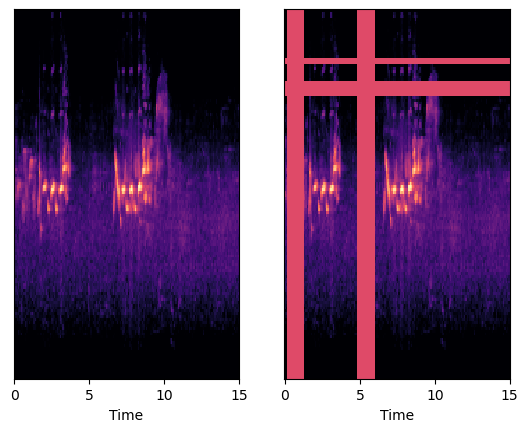

In [63]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,2)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[0]);
librosa.display.specshow(tfm_layer(spec.reshape(1, *cfg.input_dim, 1), training = True).numpy().reshape(*cfg.input_dim), 
                         sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[1]);

In [62]:
def build_model2():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    x = tfm_layer(x)
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Model2")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [36]:
model2 = build_model2()

Shape after normalization: (None, 128, 162, 1)
Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 162, 1)]     0         
                                                                 
 z_score_min_max (ZScoreMin  (None, 128, 162, 1)       0         
 Max)                                                            
                                                                 
 time_freq_mask (TimeFreqMa  (None, 128, 162, 1)       0         
 sk)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 160, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 80, 32)        0         
 g2D)                                                            
             

In [37]:
hist3 = model2.fit(training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True, verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


ValueError: in user code:

    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filev1_a71vl.py", line 69, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(training)), if_body, else_body, get_state_2, set_state_2, ('do_return', 'retval_'), 2)
    File "/tmp/__autograph_generated_filev1_a71vl.py", line 45, in else_body
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (ag__.ld(self).num_time_masks,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': '_'})
    File "/tmp/__autograph_generated_filev1_a71vl.py", line 43, in loop_body
        x = ag__.converted_call(ag__.ld(self).mask_along_axis_iid, (ag__.ld(x), ag__.ld(self).time_mask_param, 0, 2 + ag__.converted_call(ag__.ld(int), (ag__.ld(self).time_last,), None, fscope), ag__.ld(self).time_mask_prob), None, fscope)
    File "/tmp/__autograph_generated_file349l6l4z.py", line 83, in tf__mask_along_axis_iid
        ag__.if_stmt(ag__.converted_call(ag__.ld(tf).random.uniform, ([],), None, fscope) > ag__.ld(p), if_body_2, else_body_2, get_state_2, set_state_2, ('do_return', 'retval_', 'specs'), 2)
    File "/tmp/__autograph_generated_file349l6l4z.py", line 60, in else_body_2
        min_value = ag__.converted_call(ag__.ld(tf).random.uniform, (), dict(shape=ag__.ld(shape)[:2], dtype=ag__.ld(dtype)), fscope) * (ag__.ld(specs).shape[ag__.ld(axis)] - ag__.ld(value))

    ValueError: Exception encountered when calling layer 'time_freq_mask' (type TimeFreqMask).
    
    in user code:
    
        File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/tensorflow_extra/layers.py", line 402, in call  *
            x = self.mask_along_axis_iid(
        File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/tensorflow_extra/layers.py", line 442, in mask_along_axis_iid  *
            min_value = tf.random.uniform(shape=shape[:2], dtype=dtype) * (
    
        ValueError: None values not supported.
    
    
    Call arguments received by layer 'time_freq_mask' (type TimeFreqMask):
      • inputs=tf.Tensor(shape=(None, None, None, None), dtype=float32)
      • training=True
